In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from pyckmeans import CKmeans
from pyckmeans import MultiCKMeans
import ClusterEnsembles as CE
from sklearn.metrics import jaccard_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import calinski_harabasz_score

In [68]:
# load the iris data
iris=load_iris()
df=pd.DataFrame(data=iris.data, columns=['sepal length','sepal width','petal length','petal width'])
df['target']=pd.Series(iris.target)
def define_species(df, target_column):
    species = ["cluster_" + str(val) for val in target_column]
    df['Species'] = species
define_species(df, np.array(df.target))

<AxesSubplot: >

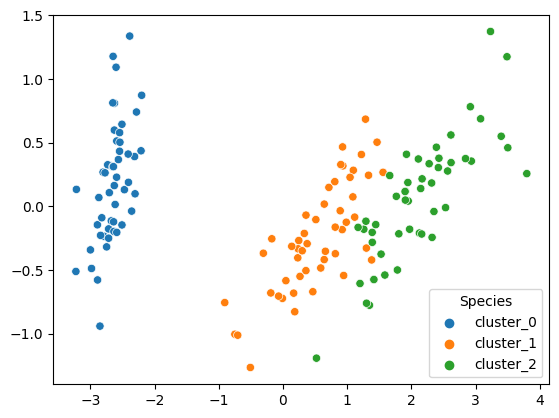

In [69]:
#  transform the actual data and display it
data = iris.data
target = iris.target
X_reduced = PCA(n_components=2).fit_transform(data)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [70]:
# KMeans from sklearn to cluster the iris data with k = [2, 3, 4, 5]
KMeans_k2 = KMeans(n_clusters=2)
k2_model = KMeans_k2.fit(iris.data)

KMeans_k3 = KMeans(n_clusters=3)
k3_model = KMeans_k3.fit(iris.data)

KMeans_k4 = KMeans(n_clusters=4)
k4_model = KMeans_k4.fit(iris.data)

KMeans_k5 = KMeans(n_clusters=5)
k5_model = KMeans_k5.fit(iris.data)

<AxesSubplot: >

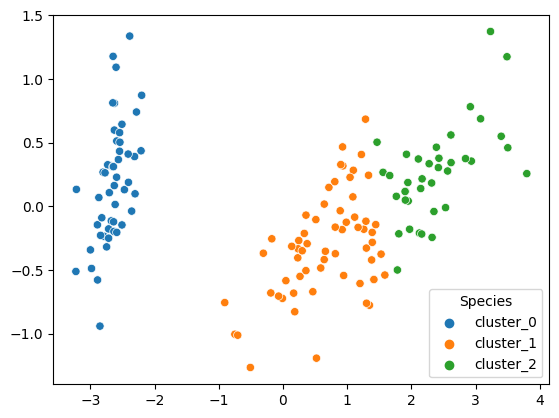

In [71]:
# display the result of using KMeans with k = 3
define_species(df, k3_model.labels_)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [72]:
#Compare the actual Data with the result of using KMeans with k = 3
print("Jacard Score = ", jaccard_score(np.array(df['target']), k3_model.labels_, average='weighted'))
print("DBI = ", davies_bouldin_score(X_reduced, k3_model.labels_))
print("silhouette_score = " , silhouette_score(X_reduced, k3_model.labels_))
# to see the different with the actual data
pd.crosstab(iris.target, k3_model.labels_)

Jacard Score =  0.8141025641025641
DBI =  0.5616707465572127
silhouette_score =  0.598794838893478


col_0,0,1,2
row_0,,,
0,50,0,0
1,0,48,2
2,0,14,36


<AxesSubplot: >

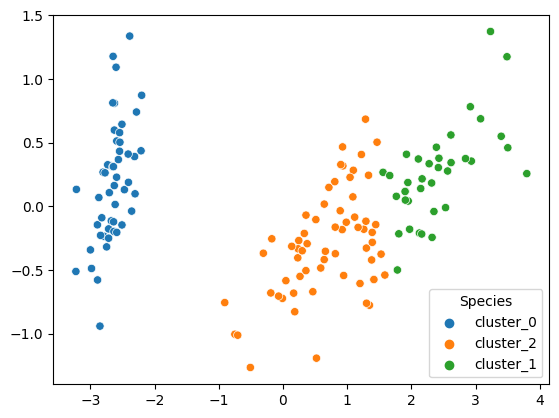

In [73]:
# Ensemble Clustering using CKmeans with a single k = 3
ckm = CKmeans(k=3, n_rep=100)
ckm.fit(iris.data)
ckm_res = ckm.predict(iris.data)
define_species(df, ckm_res.cl)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [74]:
# the different between the CKmeans and the actual data
pd.crosstab(iris.target, ckm_res.cl)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,1,49
2,0,36,14


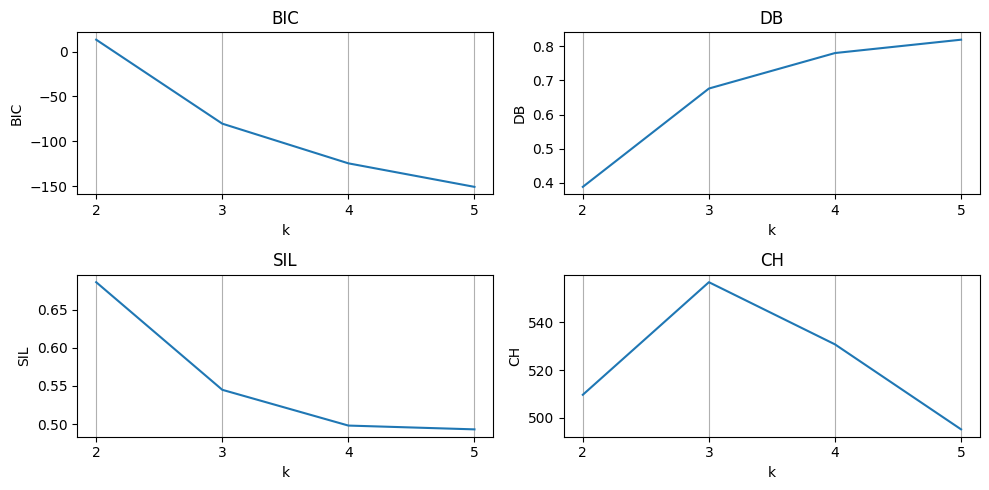

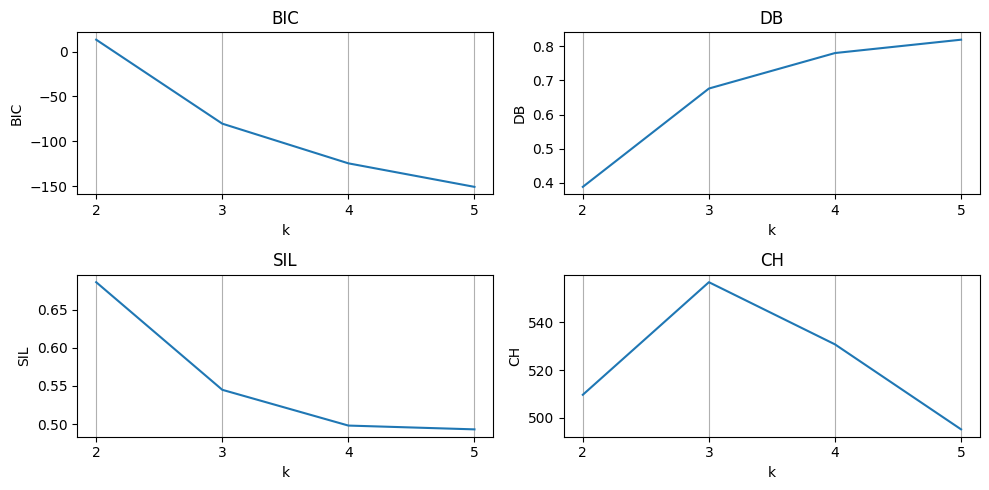

In [75]:
# Ensemble Clustering using CKmeans with a multi k = [2, 3, 4, 5]
mckm = MultiCKMeans(k=[2, 3, 4, 5], n_rep=100)
mckm.fit(iris.data)
mckm_res = mckm.predict(iris.data)
df_species = []
for i in range(4):
    define_species(df, mckm_res.ckmeans_results[i].cl)
    df_species.append(df['Species'])

# plot clustering metrics against k
# BIC, DB: lower is better
# SIL, CH: higher is better
mckm_res.plot_metrics(figsize=(10,5))

<AxesSubplot: >

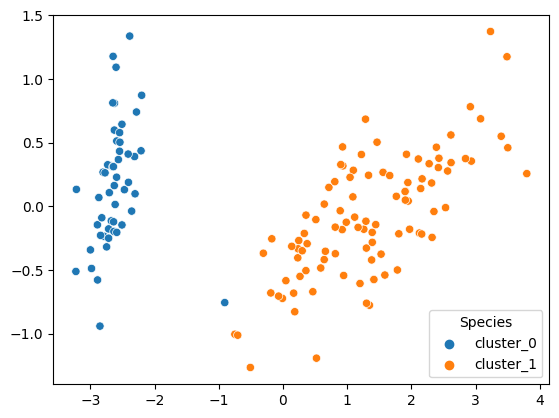

In [76]:
# display the result for each k
df['Species'] = df_species[0]
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

<AxesSubplot: >

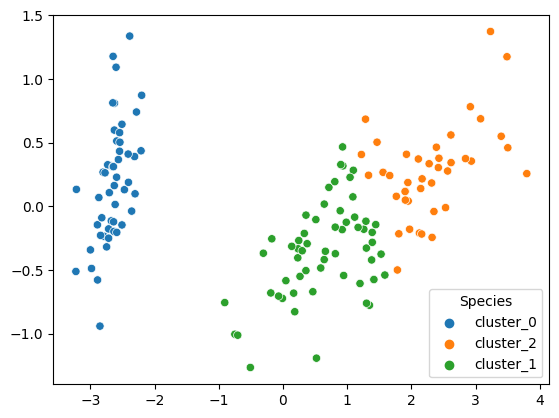

In [77]:
df['Species'] = df_species[1]
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

<AxesSubplot: >

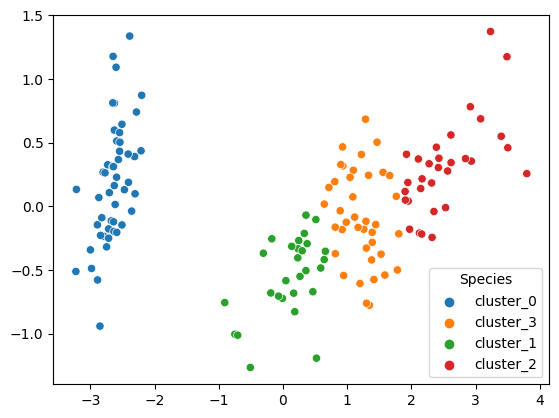

In [78]:
df['Species'] = df_species[2]
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

<AxesSubplot: >

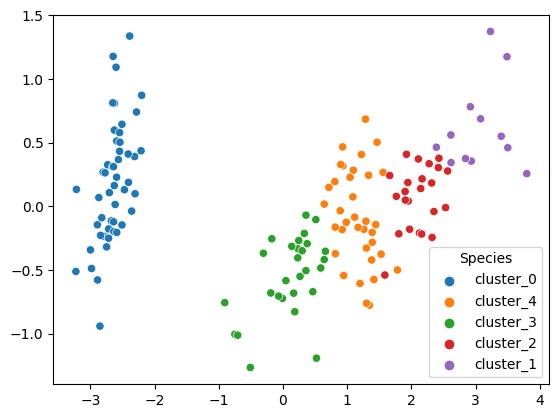

In [79]:
df['Species'] = df_species[3]
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [83]:
'''
Ensemble Clustering using algo_name ['cspa', 'mcla', 'hbgf', 'nmf'] from ClusterEnsembles
Input = results of Kmeans models from earlier with k = [2, 3, 4, 5]
compare the result of algo_name with the actual data and display the difference for k = 3 (best k)
'''
def useEnsembleClustering(algo_name, best_k, ensemble_input, k_list):
    print(f'The result of {algo_name}')
    scores = []
    for k in k_list:
        label_pred = CE.cluster_ensembles(ensemble_input, nclass=k, solver=algo_name)
        if k == best_k:
            print(pd.crosstab(iris.target, label_pred))
        scores_for_k = []
        scores_for_k.append(jaccard_score(iris.target, label_pred, average='weighted'))
        scores_for_k.append(davies_bouldin_score(X_reduced, label_pred))
        scores_for_k.append(silhouette_score(X_reduced, label_pred))
        scores_for_k.append(normalized_mutual_info_score(iris.target, label_pred, average_method='geometric'))
        scores_for_k.append(adjusted_rand_score(iris.target, label_pred))
        scores_for_k.append(fowlkes_mallows_score(iris.target, label_pred))
        scores_for_k.append(calinski_harabasz_score(X_reduced, label_pred))
        scores.append(scores_for_k)
    print("jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score")
    for element in scores:
        print(element)
ensemble_input = np.array([k2_model.labels_, k3_model.labels_, k4_model.labels_, k5_model.labels_])
useEnsembleClustering('cspa', 3, ensemble_input, [2, 3, 4, 5])

The result of cspa
col_0   0   1   2
row_0            
0      50   0   0
1       0  45   5
2       0   7  43
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.30976430976430974, 0.6000747480570108, 0.5564102199867049, 0.4923969924965998, 0.4222073739653875, 0.6647150695408485, 325.1558141466346]
[0.8570972886762361, 0.6799924558953151, 0.5289599652842392, 0.7781977339318392, 0.7859859304356341, 0.8564048044104353, 546.1545299920673]
[0.45483175150992233, 0.8209952246968643, 0.37396269907373797, 0.6206548944505879, 0.5334682913988956, 0.6717620676677667, 289.04287885780445]
[0.28037095919448857, 1.5140710098079897, 0.17203639594634249, 0.5697611939197434, 0.4289732066290561, 0.5883272335188721, 221.1529455676885]


<AxesSubplot: >

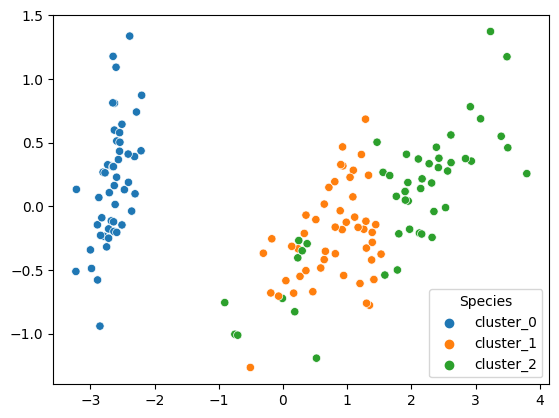

In [84]:
# display the results of CSPA for k = 3
define_species(df, labels_cspa_3)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [85]:
useEnsembleClustering('mcla', 3, ensemble_input, [2, 3, 4, 5])

The result of mcla
col_0   0   1   2
row_0            
0       0  50   0
1       0   0  50
2      35   0  15
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.3034733297891193, 0.6063002514330158, 0.5502618806578145, 0.49202100985966846, 0.42170473204955966, 0.6644337892632212, 317.43280023166574]
[0.05, 0.5556643397217115, 0.5986022445930618, 0.7980674205365927, 0.7455038681804481, 0.8320502943378437, 682.5581334068338]
[0.7385620915032679, 0.6412140272796995, 0.5463897839171122, 0.7212578493430357, 0.6726086273696161, 0.7729044775149311, 677.9806762040864]
[0.3915463917525773, 0.8187082466994606, 0.4835157554525415, 0.7699559881505317, 0.7223767009052948, 0.8141431489434866, 392.0328632743304]


In [86]:
useEnsembleClustering('hbgf', 3, ensemble_input, [2, 3, 4, 5])

The result of hbgf
col_0   0   1   2
row_0            
0      50   0   0
1       0  10  40
2       0  38  12
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.0, 1.6293773628428552, 0.3840355238573033, 0.5297783520989048, 0.4396419301869802, 0.6755039956821351, 37.99523990590382]
[0.4156565656565656, 0.7882135898230141, 0.49432589252437914, 0.6806461930707096, 0.6522271369579056, 0.7666577147135653, 470.54017308664794]
[0.28517621737960724, 3.816830726348118, 0.19125342627962963, 0.505501787952358, 0.3903536341202216, 0.5676609569385775, 59.12309127136317]
[0.45164319248826285, 2.0163345589578054, 0.15741596442001204, 0.5393712547465415, 0.3898966168266283, 0.5578295896825706, 195.84401624740462]


In [87]:
useEnsembleClustering('nmf', 3, ensemble_input, [2, 3, 4, 5])

The result of nmf
col_0   0   1   2
row_0            
0      20   0  30
1       3  47   0
2       0  50   0
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.0, 0.34936294249754146, 0.7112353733227553, 0.7611702597222872, 0.5681159420289855, 0.7714542762891773, 557.4610324586056]
[0.2824528301886792, 2.5375286713605227, 0.4371074650708255, 0.5975609375878933, 0.4275233228348569, 0.6620613161648775, 286.82725570900936]
[0.05, 3.5162233132003182, 0.31153653012690424, 0.7331162036868627, 0.6322396433818785, 0.7489922558299826, 453.36364445320305]
[0.03333333333333333, 1.051672617711441, 0.4411426557830594, 0.7263057988693546, 0.6632075994481825, 0.7660259395577179, 532.232125201266]
